# Explaining logistic regression model predictions with Shapley values

Shapley values provide an estimate of how much any particular feature influences the model decision. When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a model-agnostic measure of a feature’s influence. This means that the influence of features may be compared across model types, and it allows black box models like neural networks to be explained, at least in part.

For more on Shapley values in general see Chris Molner’s excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html


More information on the shap library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using shap with logistic regression.

NOTE: The Shap values are calculated from models using standardised data. For clarity of plotting we replace those data with non-standardised values.

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from scipy.special import expit # log odds to probability transformation

## Load data

We will use the first train/test split.

In [2]:
data_loc = '../../data/sam_1/kfold_5fold/'

train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')

## Function to standardise data

In [3]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Fit logistic regression model

Fit model and get feature weights (coefficients).

In [4]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

# Standardise X data
X_train_std, X_test_std = standardise_data(X_train, X_test)

# Define and Fit model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_std, y_train)

# Get feature weights
features = list(X_train)
feature_weights = model.coef_[0]
weights = pd.DataFrame(index=features)
weights['weights'] = feature_weights
weights['abs_weights'] = np.abs(feature_weights)
weights['rank'] = weights['abs_weights'].rank(ascending=False).values

# Get predicted class and ptrobability
y_pred = model.predict(X_test_std)
y_prob = model.predict_proba(X_test_std)[:, 1]

# Measure accuracy
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.831


## Shap values

### Get Shap values

We will get the Shap values for the test set.

In [5]:
# We pass data to Shap as a DataFrame with feature names
X_train_std_df = pd.DataFrame(X_train_std, columns=list(X_train))
X_test_std_df = pd.DataFrame(X_test_std, columns=list(X_train))

# Set up explainer using typical feature values from training set
# Note: Use a sample of 100-1000 for this if explainer too slow
explainer = shap.Explainer(model, X_train_std_df)

# To get Shapley values for test set alone:
#shap_values = explainer.shap_values(X_test_std_df)

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test_std_df)
shap_values = shap_values_extended.values

# Get mean Shap values for each feature
shap_values_mean = pd.DataFrame(index=features)
shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values

### Compare top 10 weights and Shap values

In [6]:
top_10_weights = weights.sort_values('abs_weights', ascending=False).head(10)
top_10_weights

,weights,abs_weights,rank
S2BrainImagingTime_min,-18.407809,18.407809,1.0
S2StrokeType_Infarction,2.649350,2.649350,2.0
S2StrokeType_Primary Intracerebral Haemorrhage,-2.644048,2.644048,3.0
S2RankinBeforeStroke,-0.503190,0.503190,4.0
AFAnticoagulent_Yes,-0.394665,0.394665,5.0
Loc,-0.374931,0.374931,6.0
BestLanguage,0.306440,0.306440,7.0
S1OnsetTimeType_Best estimate,-0.292378,0.292378,8.0
S1OnsetTimeType_Precise,0.292378,0.292378,9.0
S1OnsetDateType_Stroke during sleep,-0.290351,0.290351,10.0


When looking for the most influential Shap values we use the mean of the absolute Shap values for each feature.

In [7]:
top_10_shap = shap_values_mean.sort_values(
    'mean_abs_shap', ascending=False).head(10)
top_10_shap

,mean_shap,abs_mean_shap,mean_abs_shap,rank
S2BrainImagingTime_min,-1.096823,1.096823,2.307990,1.0
S2StrokeType_Infarction,0.380825,0.380825,2.139809,2.0
S2StrokeType_Primary Intracerebral Haemorrhage,0.392922,0.392922,2.137760,3.0
S2RankinBeforeStroke,-0.037584,0.037584,0.405992,4.0
S1OnsetTimeType_Best estimate,0.013593,0.013593,0.286394,5.0
S1OnsetTimeType_Precise,0.013593,0.013593,0.286394,6.0
AFAnticoagulent_Yes,0.009188,0.009188,0.266640,7.0
BestLanguage,0.050848,0.050848,0.258663,8.0
Loc,-0.028140,0.028140,0.230642,9.0
S1OnsetToArrival_min,-0.024913,0.024913,0.220880,10.0


Get intersection between top 10 weights and top 10 Shap values.

In [8]:
intersection = list(top_10_weights.index.intersection(top_10_shap.index))
print(f'Number of intersection values = {len(intersection)}')
print('\nIntersecting values:')
intersection

Number of intersection values = 9

Intersecting values:


['S2BrainImagingTime_min',
 'S2StrokeType_Infarction',
 'S2StrokeType_Primary Intracerebral Haemorrhage',
 'S2RankinBeforeStroke',
 'AFAnticoagulent_Yes',
 'Loc',
 'BestLanguage',
 'S1OnsetTimeType_Best estimate',
 'S1OnsetTimeType_Precise']

## Create Shap object with probability rather than log odds

By default, SHAP explains models in terms of their margin output before the logistic link function [https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html], hence the x axis units in the waterfall plot are log-odds units, and not probability

For the transform we use the `expit` function from scipy.

*expit(x) = 1/(1+exp(-x))*

These are beneficial mathematically as log odds are additive in their influence. But log odds are not as easy to understand to many we are trying to explain the model to, so here we transform the log odds Shap values to probability.

In [9]:
def shap_transform_scale(original_shap, y_prob):
    """
    Transform of odds shap values to probability. Based on content from:
    https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c
    
    Create a copy of the extended shap object and replace shap values and 
    base values.    
    """
    
    # Create a copy of the original extended shap values
    shap_values_transformed = deepcopy(original_shap)
    
    # Get original base values
    untransformed_base_value = original_shap.base_values[-1]
    
    # Computing the original_explanation_distance to construct the 
    # distance_coefficient used later on. This is the total shap values for each
    # instance.These are added to base value to get final prediction.
    untransformed_distance_to_explain = np.sum(original_shap.values, axis=1)
    
    # Convert model base value to probability
    transformed_base_value = expit(untransformed_base_value)
    
    # Distance (in probability) between model base and model predicted
    transformed_distance_to_explain = y_prob - transformed_base_value
    
    # The distance_coefficient is the ratio between log odds distance to explain
    # and probability to explain
    distance_coefficient = (
        transformed_distance_to_explain / untransformed_distance_to_explain)
    
    # Reshape to allow broadcasting
    distance_coefficient = distance_coefficient.reshape(-1,1)
    
    # Tansform the original shapley values to the new (probability) scale
    shap_values_transformed.values = original_shap.values * distance_coefficient
    
    # Store transformed base value
    shap_values_transformed.base_values = transformed_base_value

    #return shap_values_transformed
    return shap_values_transformed

In [10]:
shap_values_extended_probs = shap_transform_scale(shap_values_extended, y_prob)

## Shap plots

### For plotting replace standardised data values with original values

In [11]:
# Create a copy of shap_values_extended objects and replace data
shap_values_extended_ns = deepcopy(shap_values_extended)
# Replace .data with non-strandardised data
shap_values_extended_ns.data = X_test.values

shap_values_probs_ns = deepcopy(shap_values_extended_probs)
# Replace .data with non-strandardised data
shap_values_probs_ns.data = X_test.values

### Plot average Shap values against average weights

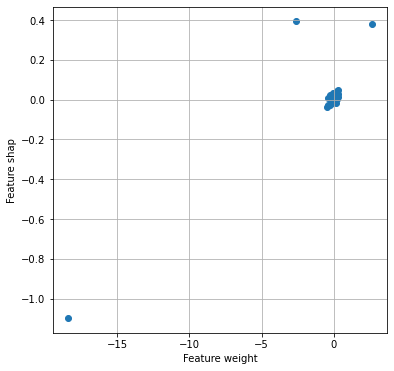

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(weights['weights'], shap_values_mean['mean_shap'])
ax.grid()
ax.set_xlabel('Feature weight')
ax.set_ylabel('Feature shap')
plt.show()

### Plot most influential features

This is a plot of the mean ansolute Shap values.

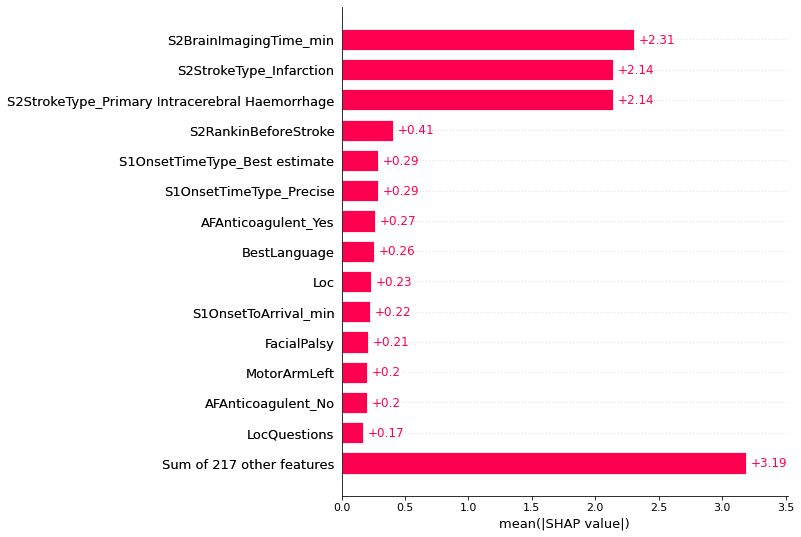

In [13]:
shap.plots.bar(shap_values_extended_ns, max_display=15)

Use summary plot to plot overall effect, without sum of other features.

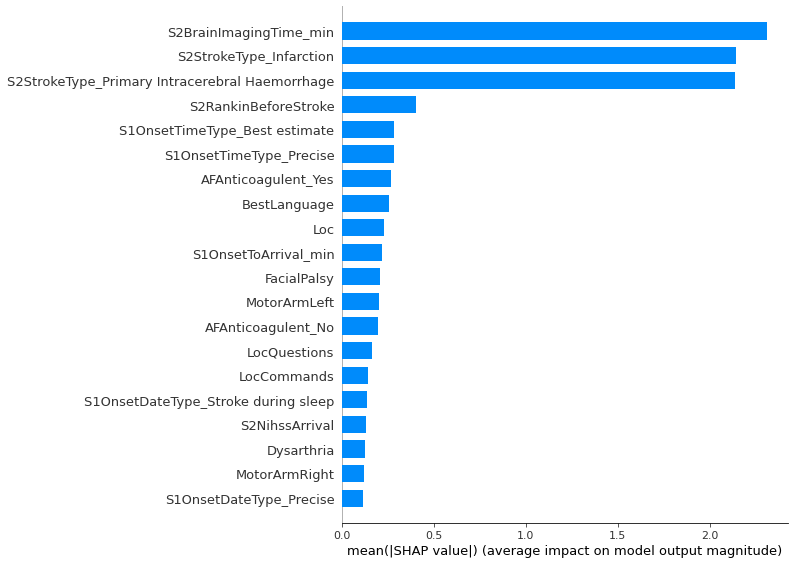

In [14]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

Show summary for probabilities (rather than log odds).

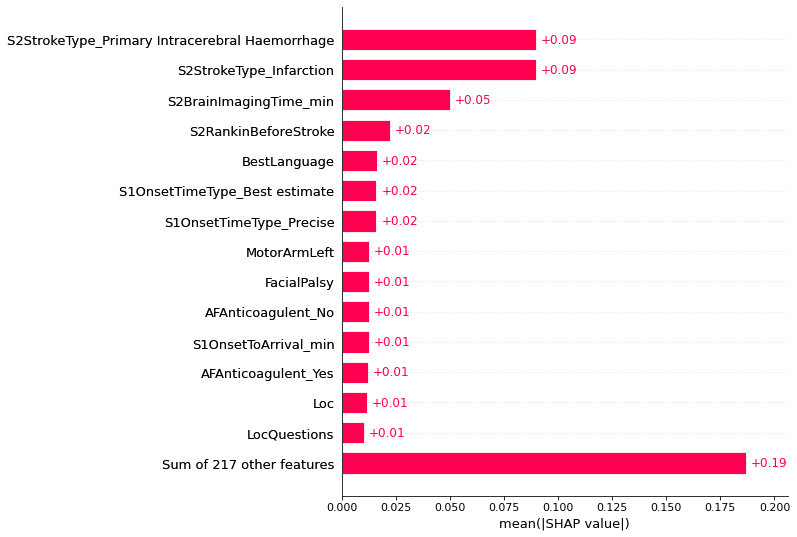

In [15]:
shap.plots.bar(shap_values_probs_ns, max_display=15)

### Bar chart for individual case

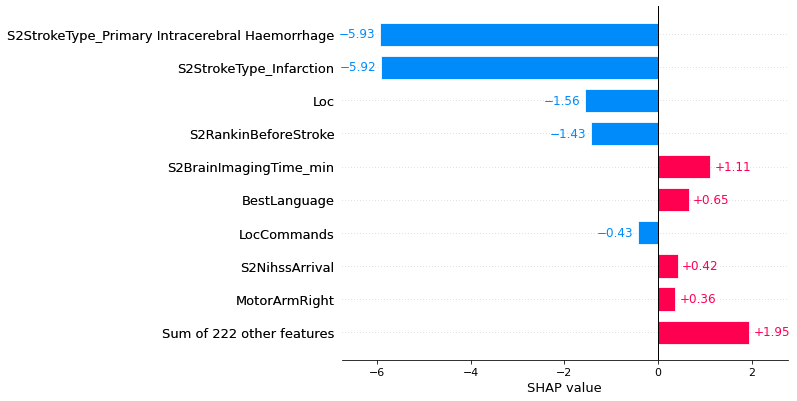

In [16]:
shap.plots.bar(shap_values_extended_ns[0]) # For the first observation

Show plot for probabilities (rather than log odds).

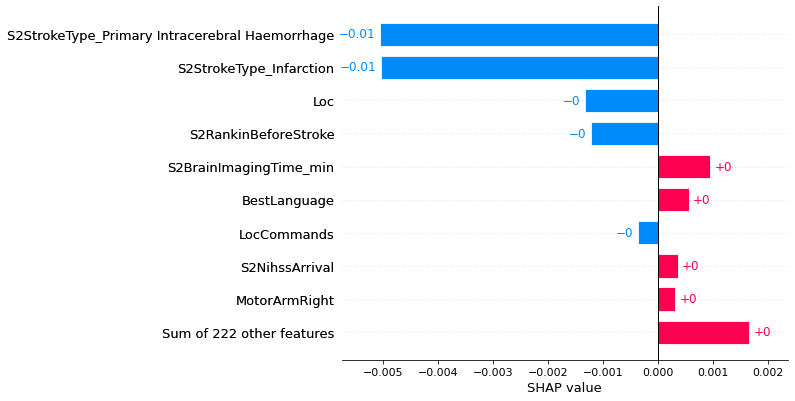

In [17]:
shap.plots.bar(shap_values_probs_ns[0]) # For the first observation

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

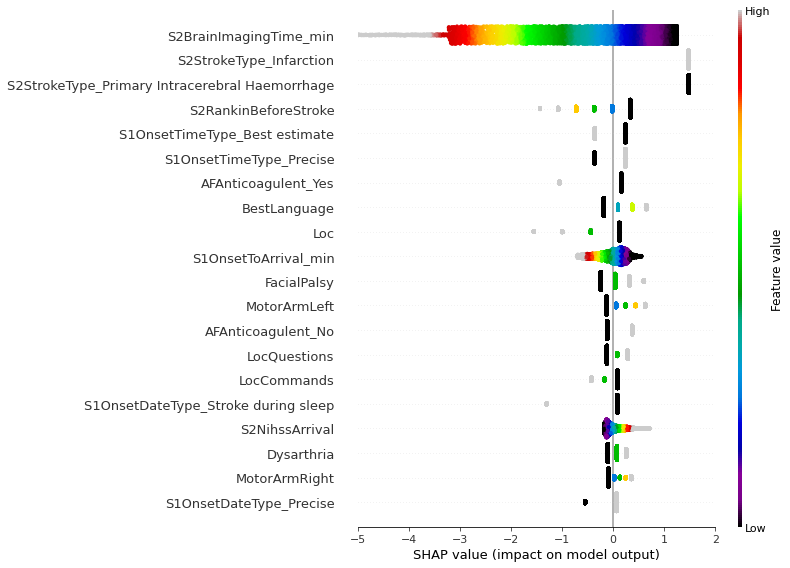

In [18]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test_std,
                  feature_names=features,
                  cmap=plt.get_cmap('nipy_spectral'),
                  show=False)
# Truncate x axis
plt.xlim(-5,2)
plt.show()

Show plot for probabilities (rather than log odds).

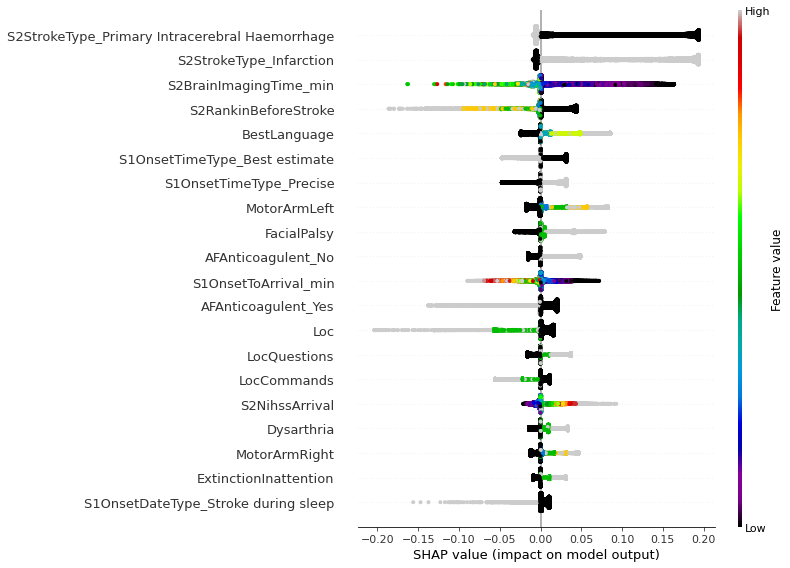

In [19]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values_probs_ns.values, 
                  features=X_test_std,
                  feature_names=features, 
                  cmap=plt.get_cmap('nipy_spectral'))

### Plot Waterfall and decision plot plots for instances with low or high probability of receiving thrombolysis

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [20]:
# Get the location of an example each where porbability of giving thrombolysis
# is <0.01 or >0.99

location_low_probability = np.where(y_prob < 0.01)[0][0]
location_high_probability = np.where(y_prob > 0.99)[0][0]

Example of a person with low probability of receiving thrombolysis.

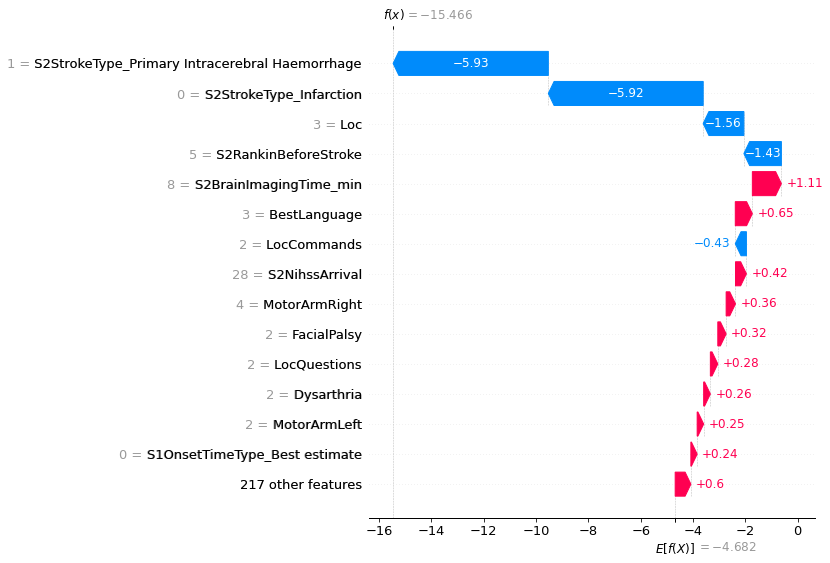

In [21]:
shap.plots.waterfall(shap_values_extended_ns[location_low_probability], 
                     max_display=15)

And as probabilities.

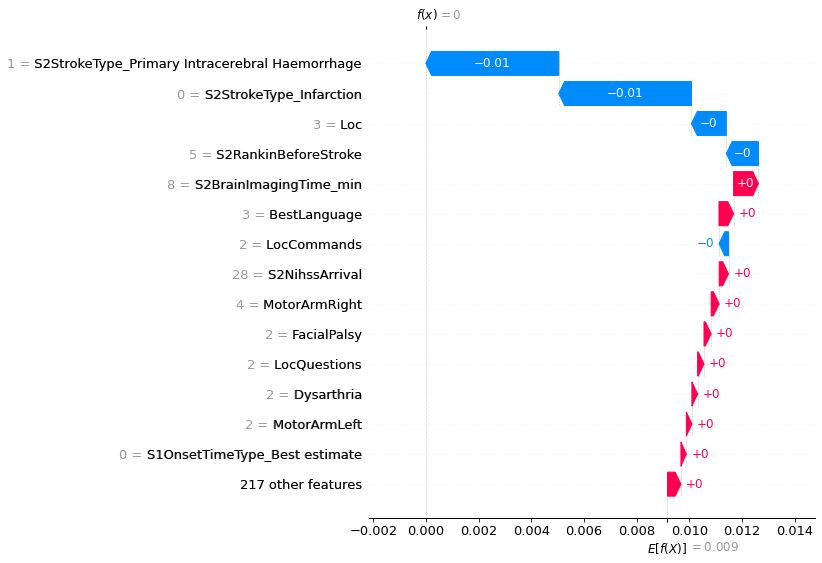

In [22]:
shap.plots.waterfall(shap_values_probs_ns[location_low_probability], 
                     max_display=15)

'Decision plot':

The base value is -4.68


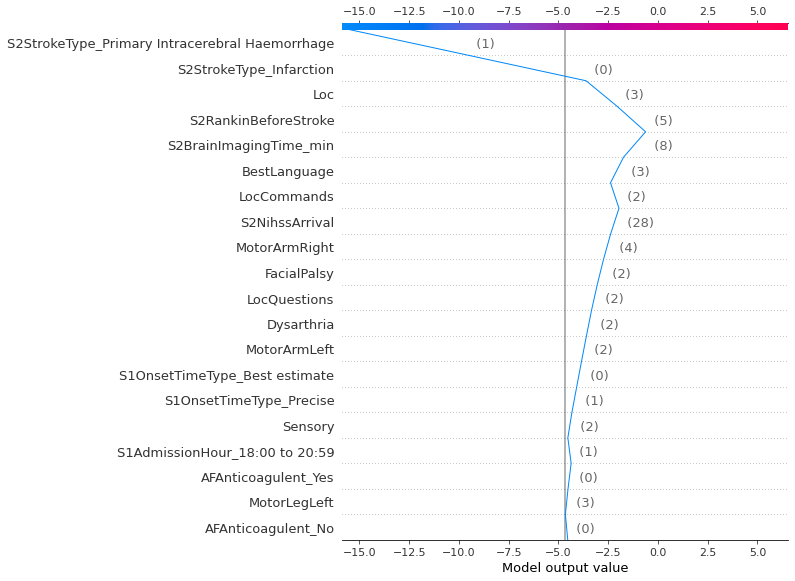

In [23]:
instance = location_low_probability

# Get instance from corresponding non-standardised data
chosen_instance = X_test.iloc[instance]
shap_values_instance = shap_values[instance]
expected_value = shap_values_extended_ns.base_values[0]#explainer.expected_value
print(f"The base value is {expected_value:0.2f}")


shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

Example of a person high low probability of receiving thrombolysis.

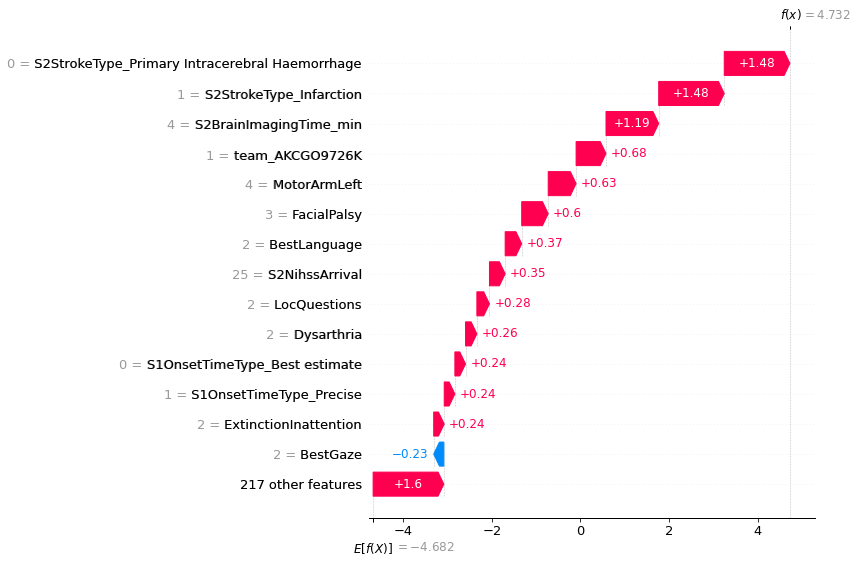

In [24]:
shap.plots.waterfall(shap_values_extended_ns[location_high_probability], 
                     max_display=15)

As probabilities:

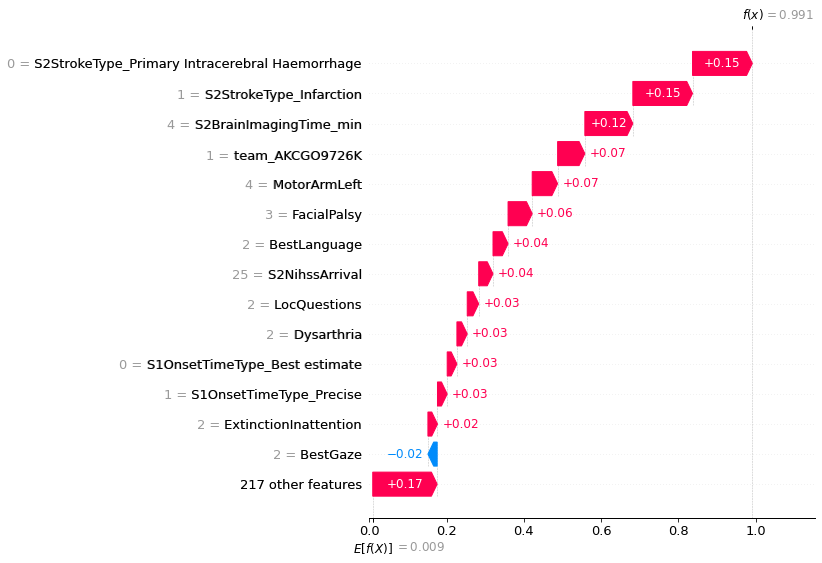

In [25]:
shap.plots.waterfall(shap_values_probs_ns[location_high_probability], 
                     max_display=15)

The base value is -4.68


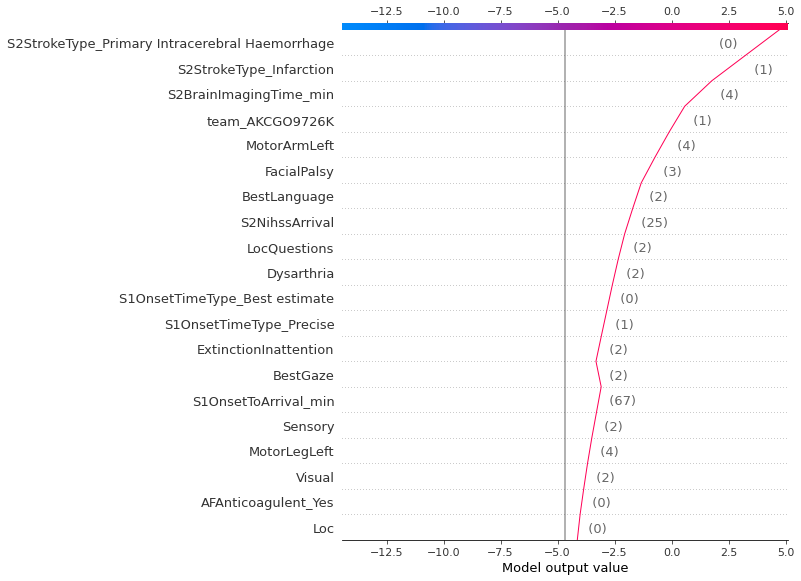

In [26]:
instance = location_high_probability

# Get instance from corresponding non-standardised data
chosen_instance = X_test.iloc[instance]
shap_values_instance = shap_values[instance]
expected_value = shap_values_extended_ns.base_values[0]#explainer.expected_value
print(f"The base value is {expected_value:0.2f}")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

### Show the relationship between feature value and Shap value for top 5 influential features.

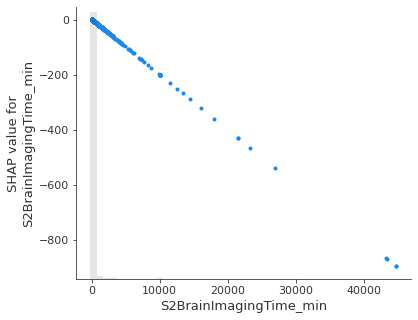

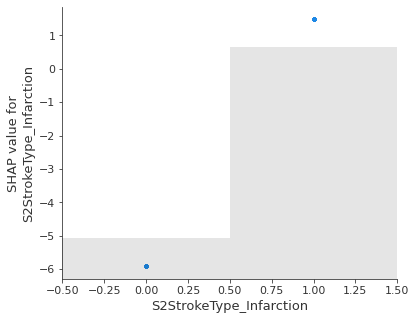

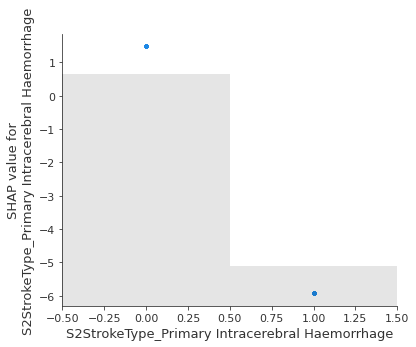

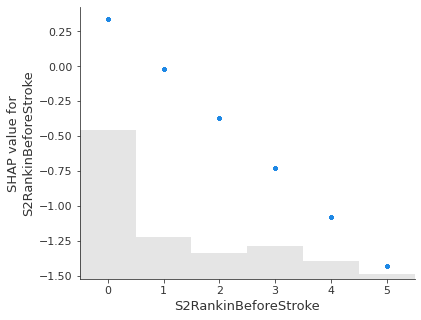

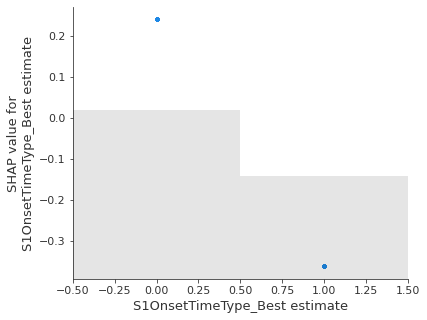

In [27]:
feat_to_show = top_10_shap.index[0:5]

for feat in feat_to_show:
    shap.plots.scatter(shap_values_extended_ns[:, feat], x_jitter=0)

Examine `S2BrainImagingTime_min` in range 0-400 minutes.

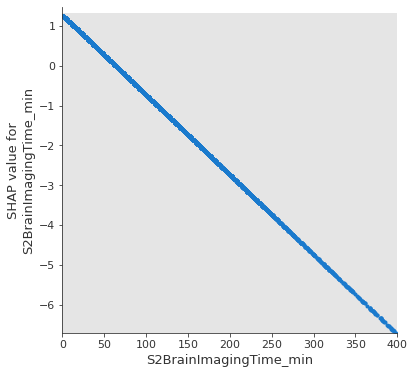

In [28]:
# Feature to look at 
feature = 'S2BrainImagingTime_min'
cutoff= 400

# Get Shap min and max below feature cutoff
mask = shap_values_extended_ns[:, feature].data < cutoff
ymax = shap_values_extended_ns.values[mask].max()
ymin = shap_values_extended_ns.values[mask].min()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
shap.plots.scatter(shap_values_extended_ns[:, feature], 
                   x_jitter=0, ax=ax, show=False)
ax.set_xlim(0,cutoff)
ax.set_ylim(ymin, ymax)
plt.show()

Examine `S2BrainImagingTime_min` in range 0-400 minutes as probabiltities.
Converting to probabilities has distorted the overall effect.

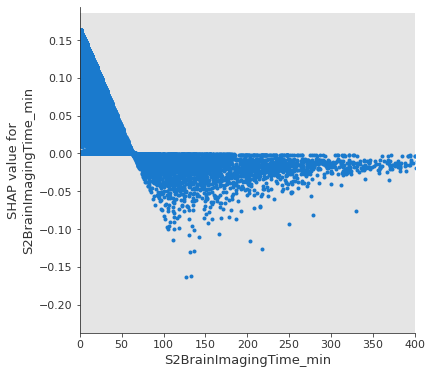

In [29]:
# Feature to look at 
feature = 'S2BrainImagingTime_min'
cutoff= 400

# Get Shap min and max below feature cutoff
mask = shap_values_probs_ns[:, feature].data < cutoff
ymax = shap_values_probs_ns.values[mask].max()
ymin = shap_values_probs_ns.values[mask].min()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
shap.plots.scatter(shap_values_probs_ns[:, feature], 
                   x_jitter=0, ax=ax, show=False)
ax.set_xlim(0,cutoff)
ax.set_ylim(ymin, ymax)
plt.show()

## Observations

* Shap show global and individual influence of features
* Shap is based off the original model structure: in a logistic regression model, this means using standardised data and explaining influence (shap values) as log odds ratio
* To make the model more explainable these paramters may be transformed to non-standardised data and probability
* Probability values may distort the feature infleunce (e.g. especially when all probs are low - this hides influence that is revealed in log odds).